In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

mpl.rcParams['figure.figsize'] = 20, 10

## Loss function

In [2]:
def quantile_error(q, y, f):
    #e = (y - f)
    e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)


input


In [5]:
def generate_synth_tseries(t0: int, series_lenght: int, num_ts: int, period: int, freq: int, noise_level: float) -> pd.DataFrame:
    """
    Generate n seasonal synthetic time series starting at t0. It allows to control the series length, seasonal period,
    time frequency resolution and added noise
    """
    time_series = []
    for k in range(num_ts):
        level = 10 * np.random.rand()
        seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
        sig = noise_level * level # noise parameter (constant in time)
        time_ticks = np.array(range(series_lenght))
        source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
        noise = sig*np.random.randn(series_lenght)
        data = source + noise
        index = pd.date_range(start=t0, freq=freq, periods=series_lenght)
        time_series.append(pd.Series(data=data, index=index))
    time_series_df = pd.DataFrame(time_series)
    return time_series_df

In [6]:
def split_sequence(sequence: np.ndarray, n_steps: int) -> (np.ndarray, np.ndarray):
    '''
    It splits a given univariate sequence into multiple samples X where each sample has a specified
    number of time steps and the output y is a single time step
    Ref: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
def plot_ts_forecast(ts_Y_train, ts_Y_test, yhat):
    forecast_h = len(yhat)
    train_window = len(ts_Y_train)
    x_length = forecast_h+train_window
    aa=[x for x in range(x_length)]
    plt.figure(figsize=(20,8))
    plt.plot(aa[:train_window], ts_Y_train, marker='.', label="train")
    plt.plot(aa[train_window:], ts_Y_test, marker='.', label="test")
    plt.plot(aa[train_window:], yhat.reshape(-1), 'r', label="prediction")
    plt.tight_layout()
    plt.subplots_adjust(left=0.07)
    plt.xlabel('time step', size=15)
    plt.legend(fontsize=15)
    plt.show()


In [8]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

# ------LSTM
n_features = 1 # We are working with univariate series so the number of features is 1
n_steps=2 # we will work with a batch of 2 time steps

# ----- Deep Quantile Regression
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

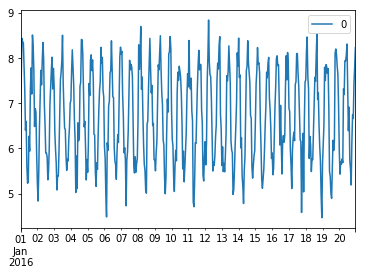

In [11]:
train_ts = time_series_df.iloc[:, 0:train_days]
test_ts = time_series_df.iloc[:,train_days-1:-1]
ts_X_test, ts_Y_test = split_sequence(test_ts.values[0], n_steps)
ts_X_train, ts_Y_train = split_sequence(train_ts.values[0], n_steps)
# reshape as input for the lstm
X = ts_X_train.reshape((ts_X_train.shape[0], ts_X_train.shape[1], n_features)) 

In [21]:
X

array([[[6.79600061],
        [7.60520371]],

       [[7.60520371],
        [8.43357507]],

       [[8.43357507],
        [8.36006716]],

       [[8.36006716],
        [8.34080072]],

       [[8.34080072],
        [7.8111614 ]],

       [[7.8111614 ],
        [7.29509643]],

       [[7.29509643],
        [6.40496917]],

       [[6.40496917],
        [6.60075002]],

       [[6.60075002],
        [5.61357606]],

       [[5.61357606],
        [5.22855805]],

       [[5.22855805],
        [5.26525666]],

       [[5.26525666],
        [6.26905959]],

       [[6.26905959],
        [5.94019497]],

       [[5.94019497],
        [7.27493292]],

       [[7.27493292],
        [7.78315888]],

       [[7.78315888],
        [7.20360552]],

       [[7.20360552],
        [8.51105436]],

       [[8.51105436],
        [8.26037417]],

       [[8.26037417],
        [7.72681386]],

       [[7.72681386],
        [6.48630515]],

       [[6.48630515],
        [6.87808501]],

       [[6.87808501],
        [6.8

In [20]:
ts_Y_train.shape

(358,)

In [19]:
ts_Y_train # Predict value

array([8.43357507, 8.36006716, 8.34080072, 7.8111614 , 7.29509643,
       6.40496917, 6.60075002, 5.61357606, 5.22855805, 5.26525666,
       6.26905959, 5.94019497, 7.27493292, 7.78315888, 7.20360552,
       8.51105436, 8.26037417, 7.72681386, 6.48630515, 6.87808501,
       6.80492277, 5.8677682 , 5.24106178, 4.83387581, 5.45593503,
       6.46207942, 7.11631719, 7.72906347, 7.40794842, 7.93701774,
       8.34537742, 7.98772146, 6.97418542, 6.52763522, 5.90021057,
       5.89563736, 5.81296575, 5.30376609, 5.49663712, 5.99296918,
       6.97336958, 7.34846509, 7.72562618, 8.02057419, 7.31633   ,
       7.77388503, 7.37916994, 6.36177232, 5.98085041, 5.67935106,
       5.07971155, 5.39665245, 5.39102866, 5.95316086, 6.70867792,
       7.51659533, 7.68874164, 7.92784815, 8.50670271, 7.43329112,
       6.89469998, 6.44554728, 6.42033248, 5.83090119, 5.51359434,
       5.7596619 , 5.7207358 , 6.20435573, 6.47549912, 7.00442289,
       7.06197891, 7.71247577, 8.18337527, 7.78047671, 7.42030

In [18]:
ts_X_train # Start, end of serie

array([[6.79600061, 7.60520371],
       [7.60520371, 8.43357507],
       [8.43357507, 8.36006716],
       [8.36006716, 8.34080072],
       [8.34080072, 7.8111614 ],
       [7.8111614 , 7.29509643],
       [7.29509643, 6.40496917],
       [6.40496917, 6.60075002],
       [6.60075002, 5.61357606],
       [5.61357606, 5.22855805],
       [5.22855805, 5.26525666],
       [5.26525666, 6.26905959],
       [6.26905959, 5.94019497],
       [5.94019497, 7.27493292],
       [7.27493292, 7.78315888],
       [7.78315888, 7.20360552],
       [7.20360552, 8.51105436],
       [8.51105436, 8.26037417],
       [8.26037417, 7.72681386],
       [7.72681386, 6.48630515],
       [6.48630515, 6.87808501],
       [6.87808501, 6.80492277],
       [6.80492277, 5.8677682 ],
       [5.8677682 , 5.24106178],
       [5.24106178, 4.83387581],
       [4.83387581, 5.45593503],
       [5.45593503, 6.46207942],
       [6.46207942, 7.11631719],
       [7.11631719, 7.72906347],
       [7.72906347, 7.40794842],
       [7.

In [3]:
def quantile_error(y_true, parameters):
  """
  y_true: [bs, 1]
  """
  mu = parameters[:,:,:1] #[bs, N_taus, 1]
  tau = parameters[:,:,-1:] #[bs, N_taus, 1]
  y_1 = y_true[:,tf.newaxis,:] #[bs, 1, 1]
  y = tf.repeat(y_1,tf.shape(mu)[1],axis=1, name='repeat_-1') #[bs, N_taus, 1]
  return tf.reduce_mean(tf.maximum(tau*(y-mu),(tau-1.)*(y-mu)))


class Implicit_QR(tf.keras.Model):
  def __init__(self):
    super(Implicit_QR, self).__init__()
    self.h_1 = tf.keras.layers.LSTM(50, activation='relu', name='LSTM_01')
    self.h_2 = tf.keras.layers.Dense(1)

  def call(self, inputs, N_taus=100, training=True):
    """
    inputs: [bs, ts, f]
    """

    if training:
      tau = tf.random.uniform((tf.shape(inputs)[0],N_taus, 1, 1), minval=1e-2, maxval=1.-1e-2) # [bs, N_taus, 1, 1]
    else:
      tau = tf.keras.Input(shape=(1,)) #[N_taus, 1]
      tau = tf.repeat(tf.reshape(tau,(1,-1,1,1), name='reshape_0'), tf.shape(inputs)[0], name='repeat_0') # [bs, N_taus, 1, 1]
    
    i_1 = tf.keras.backend.expand_dims(inputs,axis=1) #[bs, 1, ts, f]

    #RESHAPE de INPUT y TAU
    i_b = tf.repeat(i_1, N_taus, axis=1, name='repeat_1') #[bs, N_taus, ts, f]
    
    #tf.debugging.assert_equal(tf.shape(tau)[1:], [N_taus, 1,1])
    print(tau[:,:,0].shape)
    tau_b = tf.repeat(tau, inputs.shape[1], axis=2, name='repeat_2') #[bs, N_taus, ts, 1]
    
    input_tau = tf.keras.layers.concatenate([i_b, tau_b], axis=-1) # [bs, N_taus, ts, fs+1]
    input_tau = tf.reshape(input_tau, [-1, tf.shape(inputs)[1], X.shape[-1]+1], name='repeat_3') #[bs * N_taus, ts, fs+1]

    # Model
    hidden_1 = self.h_1(input_tau)
    hidden_2 = self.h_2(hidden_1)

    output_tau = tf.keras.layers.concatenate([tf.reshape(hidden_2, tf.shape(tau[...,0]), name='reshape_4'), tau[...,0]], axis=-1)

    return output_tau

In [4]:
model = Implicit_QR()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = quantile_error)
quantile_error(y[:100].astype('float32'), model(X[:100])).shape

NameError: name 'y' is not defined

In [ ]:
model.summary()

In [ ]:
X.shape, y.shape

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.1,verbose=1, epochs=10000, callbacks=[es])

from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])

In [ ]:
model(X).shape

In [ ]:
y[:,tf.newaxis,:,tf.newaxis].shape

In [ ]:
tf.repeat(np.zeros((10,3,1)),30,axis=-1).shape

In [ ]:
X.shape

In [ ]:
model = Implicit_QR()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss = quantile_error)

In [ ]:
y = ts_Y_train.reshape((ts_Y_train.shape[0], 1))

In [ ]:
X.shape

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.1,verbose=1, epochs=10000, callbacks=[es])

from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])

In [ ]:
model(X, N_taus=105, training=True).shape

In [ ]:
ts_X_train.shape, ts_Y_train.shape, y.shape

In [ ]:
X.shape

In [ ]:
X.shape

In [ ]:
model = lstm_dqr_model(X)

In [ ]:
x_input = ts_X_test
x_input = x_input.reshape((ts_X_test.shape[0], ts_X_test.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)

In [ ]:
plot_ts_forecast(ts_Y_train, ts_Y_test, yhat)